Loading monitored datafile...


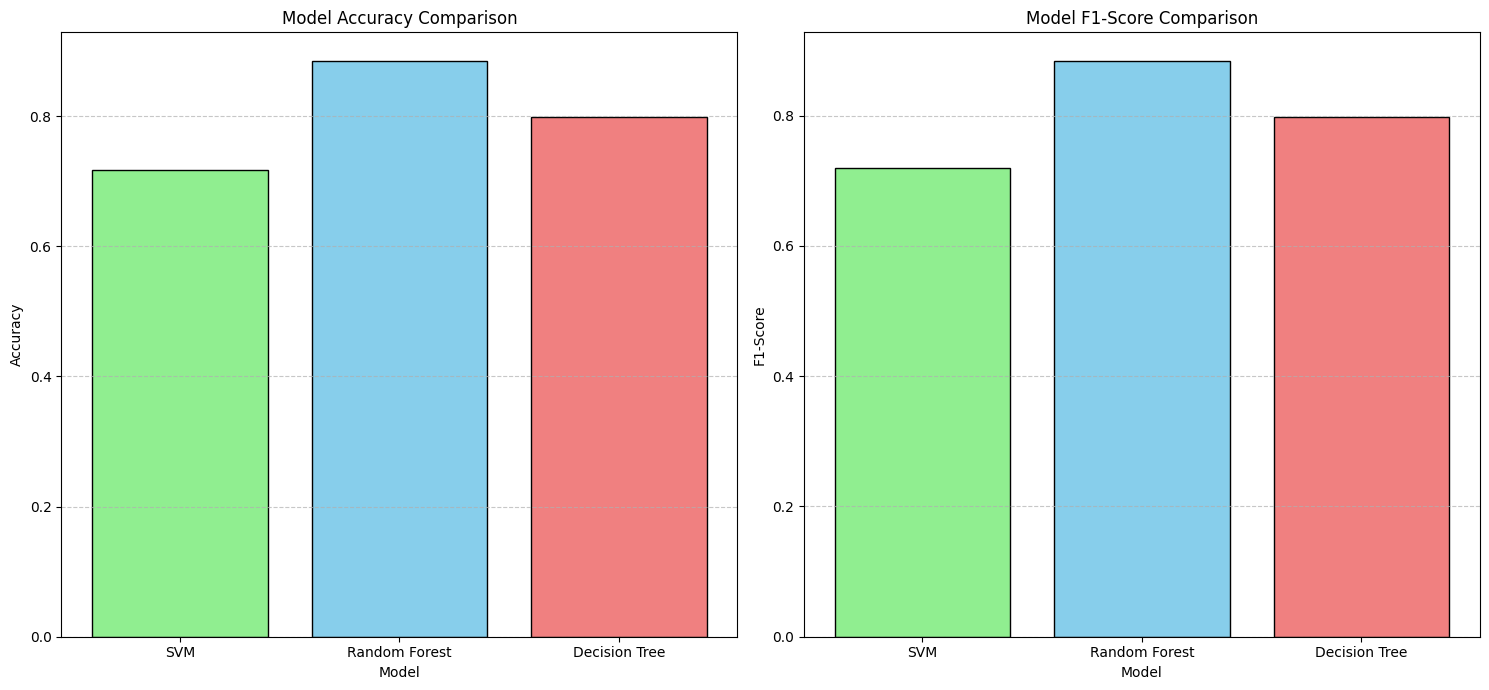

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Monitored data
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950
MAX_LENGTH = 500  # set max padding length

print("Loading monitored datafile...")
with open("/content/mon_standard.pkl", "rb") as file:
    data = pickle.load(file)

def process_sample(sample):
    timestamps = np.empty(len(sample), dtype=np.float32)
    packet_sizes = np.empty(len(sample), dtype=np.int16)
    cum_sizes = np.empty(len(sample), dtype=np.int32)
    cumulative_sum = 0

    for j, c in enumerate(sample):
        dr = 1 if c > 0 else -1
        timestamps[j] = abs(c)
        packet_sizes[j] = dr * 512
        cumulative_sum += packet_sizes[j]
        cum_sizes[j] = cumulative_sum

    return timestamps, packet_sizes, cum_sizes

def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq[:maxlen]
    return padded_sequences

X_timestamps, X_packet_sizes, X_cum_sizes, y_labels = [], [], [], []
for i in range(TOTAL_URLS):
    label = i if USE_SUBLABEL else i // URL_PER_SITE
    for sample in data[i]:
        timestamps, packet_sizes, cum_sizes = process_sample(sample)
        X_timestamps.append(timestamps)
        X_packet_sizes.append(packet_sizes)
        X_cum_sizes.append(cum_sizes)
        y_labels.append(label)

# padding
X_timestamps_padded = pad_sequences(X_timestamps, MAX_LENGTH)
X_packet_sizes_padded = pad_sequences(X_packet_sizes, MAX_LENGTH)
X_cum_sizes_padded = pad_sequences(X_cum_sizes, MAX_LENGTH)

# feature combination
X_combined = np.hstack((X_timestamps_padded, X_packet_sizes_padded, X_cum_sizes_padded))
y_combined = np.array(y_labels)

# data split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

# evaluation function 
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    f1_scores = [report[str(i)]['f1-score'] for i in range(max(y_combined) + 1)]
    return f1_scores

# model setting
svm_model = SVC(kernel="linear", random_state=42, C=1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
dt_model = DecisionTreeClassifier(random_state=42)

svm_f1_scores = train_and_evaluate_model(svm_model, X_train, y_train, X_test, y_test, "SVM")
rf_f1_scores = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")
dt_f1_scores = train_and_evaluate_model(dt_model, X_train, y_train, X_test, y_test, "Decision Tree")

# F1-Score
models = ['SVM', 'Random Forest', 'Decision Tree']
f1_scores = [np.mean(svm_f1_scores), np.mean(rf_f1_scores), np.mean(dt_f1_scores)]

# visualization
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['lightgreen', 'skyblue', 'lightcoral'], edgecolor='black')
plt.title('Model F1-Score Comparison')
plt.xlabel('Model')
plt.ylabel('Mean F1-Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()